# Fig 1B

Monogenic resistance can give low doses better sometimes

NB check that current form for data etc is most up to date fit!!

Heatmaps

In [6]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [398]:
import pandas as pd

import seaborn as sns

from math import log, floor

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap
import itertools

from plots2.fns import (
    # standard_layout,
    # corner_annotations_colwise,
    # corner_annotations_rowwise,
    # get_text_annotation,
    get_corner_annotations,
    get_corner_annotations_explicit,
    get_corner_annotations_custom_labels
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
)

from poly2.utils import get_dispersal_kernel, trait_vec, beta_dist, gamma_dist, Fungicide
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

In [12]:
sns.set_palette("viridis_r", n_colors=10)

# Get data

In [283]:
cf = Config(
    verbose=False, 
    n_k=100,
    # n_years=200,
    n_years=20,
)

cf.mutation_proportion = 0
cf.mutation_scale_fung = 1
cf.mutation_scale_host = 1

cf.print_repr()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
host_on = None
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 0
mutation_scale_fung = 1
mutation_scale_host = 1
n_k = 100
n_l = 50
n_years = 20
replace_cultivars = None
sprays = None



In [284]:
def get_mono_data(init_dist):
    doses = [0.25,1]

    df = pd.DataFrame()

    for dd in doses:
        cf.doses = dd*np.ones(cf.n_years)

        sim = SimulatorOneTrait(cf)

        sim.initial_k_dist = init_dist

        data = sim.run_model()

        tmp = pd.DataFrame(
            dict(
                yld=data['yield_vec'],
                dose=dd,
                year=data['year'],
                mean=data['fung_mean'][:-1],
            ))

        df = pd.concat([df, tmp])

    df = df.reset_index(drop=True)
    
    return df

In [285]:
pr = 1e-3

In [286]:
%%time

out = pd.DataFrame()

sim = SimulatorOneTrait(cf)
k_vec = sim.k_vec

indices = list(np.arange(0, 100, 10)) + [-1]

# indices = list(np.arange(0, 100, 25)) + [-1]

for ii, jj in tqdm(
    itertools.product(
        indices, 
        indices
    )):
    
    if k_vec[jj]<=k_vec[ii]:
        continue

    init_dist_1 = np.zeros(cf.n_k)
    init_dist_1[ii] = 1-pr
    init_dist_1[jj] = pr
    
    sim = SimulatorOneTrait(cf)
    
    

    tmp = (
        get_mono_data(init_dist_1)
        .assign(
            s = sim.k_vec[ii],
            r = sim.k_vec[jj],
        )
        .drop(['mean'], axis=1)
    )
    
    out = pd.concat([out, tmp])

out = out.reset_index(drop=True)

out.head()

121it [07:46,  3.86s/it]

Wall time: 7min 46s


,yld,dose,year,s,r
0,10.568773,0.25,1,0.005,0.005
1,10.134036,0.25,2,0.005,0.005
2,10.134036,0.25,3,0.005,0.005
3,10.134036,0.25,4,0.005,0.005
4,10.134036,0.25,5,0.005,0.005


In [389]:
data = (
    out
    .pivot(index=['s', 'r', 'year'], columns='dose', values='yld')   
    .reset_index()
    .rename(columns={0.25: 'yld_l', 1.00: 'yld_h'})
    .assign(ratio = lambda x: x.yld_h / (x.yld_l + x.yld_h))
    .loc[:, ['s', 'r', 'ratio', 'year']]
)

data.loc[lambda x: (x.s==x.r), 'ratio'] = np.nan

data.sample(10)

dose,s,r,ratio,year
79,0.005,0.305,0.519209,20
943,0.505,0.705,0.516700,4
1282,0.905,0.995,0.504078,3
579,0.205,0.905,0.503724,20
640,0.305,0.505,0.519208,1
251,0.105,0.205,0.516809,12
51,0.005,0.205,0.518851,12
158,0.005,0.705,0.511477,19
498,0.205,0.505,0.510238,19
1294,0.905,0.995,0.504039,15


In [390]:
data.loc[lambda x: x.year==1].describe()

dose,s,r,ratio,year
count,66.000000,66.000000,55.000000,66.0
mean,0.338182,0.670000,0.515229,1.0
std,0.270425,0.268736,0.004296,0.0
min,0.005000,0.005000,0.504080,1.0
25%,0.105000,0.505000,0.511466,1.0
50%,0.305000,0.705000,0.517254,1.0
75%,0.505000,0.905000,0.519012,1.0
max,0.995000,0.995000,0.519211,1.0


In [391]:
def get_df(year):
    out = (
        data
        .loc[lambda x: x.year==year]
        .set_index(['r', 's'])
        .drop('year', axis=1)
        .unstack(level=-1)    
    )

    out.columns = data.s.unique()

    return out

In [392]:
dA = get_df(5)
dB = get_df(10)
dC = get_df(15)
dD = get_df(20)

In [393]:
data.loc[lambda x: x.year.isin([5,10,15,20])].describe().loc[['min', 'max']]

dose,s,r,ratio,year
min,0.005,0.005,0.480731,5.0
max,0.995,0.995,0.519209,20.0


In [395]:
ticklabs = [0, None, None, None, None, 0.5, None, None, None, None, 1]

In [396]:
len(ticklabs)

11

In [397]:
len(data.s.unique())

11

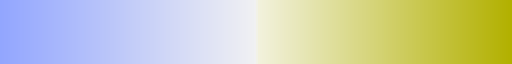

In [441]:
sns.diverging_palette(260, 85, s=100, l=70, as_cmap=True)

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


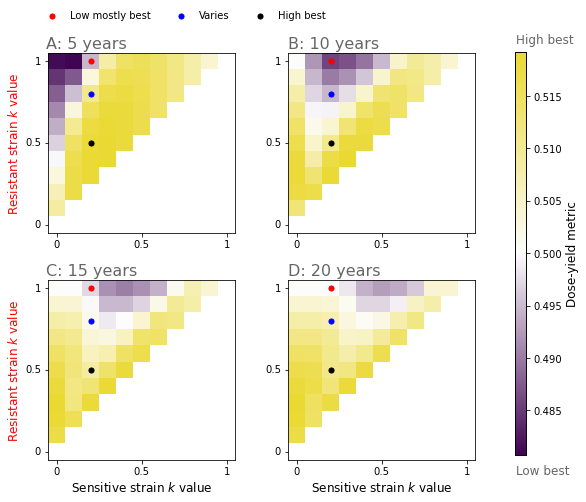

In [459]:
f, ax = plt.subplots(
    2,
    2, 
    figsize=(8,7),
)

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize

vmin=0.480731
vmax=0.519209

n_data = len(data.s.unique())

# cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
# cmap = sns.diverging_palette(250, 70, s=100, l=60, as_cmap=True)

# cmap = sns.diverging_palette(260, 85, s=100, l=70, as_cmap=True)
gg = 0.99
mid = (gg, gg, gg)
yellow1 = (0.92, 0.85, 0.2)
blue1 = (63/255,4/255, 82/255)

cvals  = [vmin, 0.5, vmax]
colors = [blue1, mid, yellow1]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm, cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)
# cmap = ScalarMappable(cmap=cm1)



cax = plt.axes([0.9, 0.1, 0.02, 0.8])

cbar_label = 'Dose-yield metric'



sns.heatmap(
    data=dA,
    ax=ax[0][0],
    center=0.5,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_ax=cax,
    cbar_kws=dict(label=cbar_label)
)

sns.heatmap(
    data=dB,
    ax=ax[0][1],
    center=0.5,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
    # cbar_kws=dict(label=cbar_label)
)

sns.heatmap(
    data=dC,
    ax=ax[1][0],
    center=0.5,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
    # cbar_kws=dict(label=cbar_label)
)

sns.heatmap(
    data=dD,
    ax=ax[1][1],
    center=0.5,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
    # cbar_kws=dict(label=cbar_label)
)


x1 = 2.5
y1 = 10.5

x2 = 2.5
y2 = 8.5

x3 = 2.5
y3 = 5.5

ss = 26

for ii, jj in itertools.product(np.arange(2), np.arange(2)):
    l1 = 'Low mostly best' if ii+jj==0 else None
    l2 = 'Varies' if ii+jj==0 else None
    l3 = 'High best' if ii+jj==0 else None
    
    ax[ii][jj].scatter([x1], [y1], c='r', s=ss, label=l1)
    ax[ii][jj].scatter([x2], [y2], c='b', s=ss, label=l2)
    ax[ii][jj].scatter([x3], [y3], c='k', s=ss, label=l3)



ax[0][0].invert_yaxis()
ax[1][0].invert_yaxis()
ax[0][1].invert_yaxis()
ax[1][1].invert_yaxis()


ax[0][0].set_ylabel(r'Resistant strain $k$ value')
ax[1][0].set_ylabel(r'Resistant strain $k$ value')
ax[0][1].set_ylabel(None)
ax[1][1].set_ylabel(None)

ax[0][0].set_xlabel(None)
ax[1][0].set_xlabel(r'Sensitive strain $k$ value')
ax[0][1].set_xlabel(None)
ax[1][1].set_xlabel(r'Sensitive strain $k$ value')


for spine in cax.spines.values():
    spine.set(visible=True, lw=.8, edgecolor="black")

for ii, jj in itertools.product(np.arange(2), np.arange(2)):
    ax[ii][jj].spines['bottom'].set_visible(True)
    ax[ii][jj].spines['left'].set_visible(True)
    ax[ii][jj].spines['top'].set_visible(True)
    ax[ii][jj].spines['right'].set_visible(True)
    
    ax[ii][jj].set_xticks([0.5, n_data/2, n_data-0.5], minor=False)
    ax[ii][jj].set_yticks([0.5, n_data/2, n_data-0.5], minor=False)
    
    ax[ii][jj].set_xticklabels([0, 0.5, 1], minor=False, rotation=0)
    ax[ii][jj].set_yticklabels([0, 0.5, 1], minor=False)
    
    if jj==0:
        ax[ii][jj].yaxis.label.set_color('red')
        ax[ii][jj].yaxis.label.set_color('red')

f.patch.set_facecolor('white')

plt.tight_layout(rect=[0,0,0.85,0.92], h_pad=3, w_pad=3)

custom_labs = [
    'A: 5 years',
    'B: 10 years',
    'C: 15 years',
    'D: 20 years',
]

get_corner_annotations_custom_labels(2, 2, 0.08, 0.9, 0.42, 0.45, plt, custom_labs)

xx = 0.895

plt.annotate(
    'Low best',
    (xx, 0.055),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=12,
)

plt.annotate(
    'High best',
    (xx, 0.91),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=12,
)

f.legend(
    loc='upper left',
    bbox_to_anchor = (0.064,1),
    framealpha=0,
    ncol=3
)

## Save

In [460]:
f.savefig('../figures/paper/fig1B.jpg', dpi=300, bbox_inches="tight")